# Imports

In [64]:
import catboost as cb
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb
import geopandas as gpd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

# Configs

In [108]:
INPUT_PATH = 'datasets/'
OUTPUT_PATH = 'results/rf_predictions.parquet'

RIDGE_TEST_PATH = 'results/ridge_test_predictions.parquet'
RIDGE_TRAIN_PATH = 'results/ridge_train_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = [#'ARIMA_predicts',
                # 'borough',
                
                # 'Previous_week_trip_dist',
                # 'Previous_2week_trip_dist',
                # 'Previous_day_trip_dist',

                # 'Previous_week_passenger_count',
                # 'Previous_2week_passenger_count',
                # 'Previous_day_passenger_count',

                # 'Previous_week_fare_amount',
                # 'Previous_day_fare_amount',
                # 'Previous_2week_fare_amount',
                'Ridge_predict',

                'Previous_week_max_demand',
                'Previous_2week_max_demand',

                'Previous_2week_demand',
                'Previous_week_demand', 

                'Previous_week_group_max_demand',
                'Previous_week_group_min_demand',
                'Previous_week_group_mean_demand',

                'Previous_day_demand',
                'Previous_2day_demand',
                'Previous_3day_demand',
                'Previous_4day_demand',
                'Previous_5day_demand',
                'Previous_6day_demand',
                'Previous_8day_demand',
                'Previous_9day_demand',
                'Previous_10day_demand',
                'Previous_11day_demand',
                'Previous_12day_demand',
                'Previous_13day_demand',

                # 'Previous_week_extra',
                # 'Previous_2week_extra',
                # 'Previous_day_extra',
                
                # 'Previous_2week_RatecodeID',
                # 'Previous_week_RatecodeID',
                # 'Previous_day_RatecodeID',

                # 'Previous_week_congestion_surcharge',
                # 'Previous_2week_congestion_surcharge',
                # 'Previous_day_congestion_surcharge',

                #  'Day_of_month', 
                #  'Day_of_week',
                #  'Location'
                ]

TEST_START_DATE = '2023-04-01'
GROUP_NUM = 3
AUTO_TUNE = False

# Data preparation


## Load Data

In [66]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [67]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [68]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672629, 3)


,tpep_pickup_datetime,PULocationID,PU_date
0,2023-01-01 00:32:10,161,2023-01-01
1,2023-01-01 00:55:08,43,2023-01-01
2,2023-01-01 00:25:04,48,2023-01-01
3,2023-01-01 00:03:48,138,2023-01-01
4,2023-01-01 00:10:29,107,2023-01-01


In [69]:
ridge_train_df = pd.read_parquet(RIDGE_TRAIN_PATH)
ridge_test_df = pd.read_parquet(RIDGE_TEST_PATH)
ridge_df = pd.concat([ridge_train_df, ridge_test_df], axis = 0)

In [70]:
print(f'ridge dataframe shape : {ridge_df.shape}')
ridge_df.head()

ridge dataframe shape : (27772, 3)


,Location,Date,Predicted_demand
0,1,2023-01-15,20.237018
1,1,2023-01-16,23.753486
2,1,2023-01-17,16.325937
3,1,2023-01-18,13.698376
4,1,2023-01-19,13.702710


In [71]:
regions_df = gpd.read_file('taxi_zones/taxi_zones.shp')
regions_df = regions_df.rename(columns = {'LocationID' : 'Location'})

## Labeling

In [72]:
def labeling(dataset, zones):
    dataset_labels = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    locations = pd.DataFrame(dataset_labels['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels, how='left', on=['Location', 'Date'])
        .fillna(value=0)
    )
    return labels_df


In [73]:
regions_df['borough'] = LabelEncoder().fit_transform(regions_df[['borough', 'Location']]['borough'])

In [74]:
labeled_df = labeling(rides_df, regions_df[['borough', 'Location']])

In [75]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (31440, 3)


,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


In [76]:
labeled_df.to_parquet('labels.parquet')

## Grouping Locations

### Agglomerative Clustering

In [77]:
location_demand_df = labeled_df.groupby('Location')['Demand'].max().to_frame('Demand').sort_values(by = 'Demand').reset_index()
clustering = AgglomerativeClustering(n_clusters = GROUP_NUM).fit(location_demand_df['Demand'].to_numpy().reshape(-1, 1))

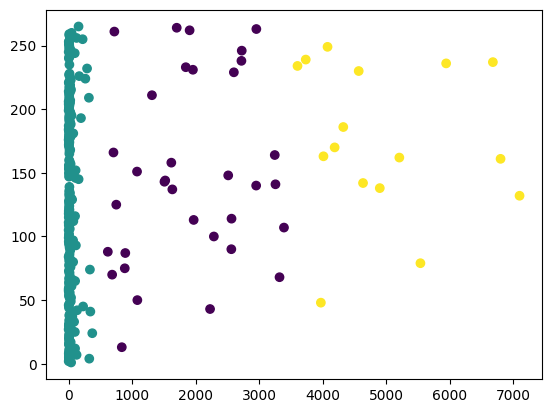

In [78]:
plt.scatter(location_demand_df['Demand'], location_demand_df['Location'], c = clustering.labels_)

In [79]:
def group_locations(location_demand_df, group_num):
    locations = [[] for i in range(group_num)]
    for i in range(group_num):
        demand_values = location_demand_df['Demand'].to_numpy().reshape(-1, 1)[clustering.labels_ == i]
        locations[i].append(
            location_demand_df[(location_demand_df['Demand'] >= np.min(demand_values))
            &(location_demand_df['Demand'] <= np.max(demand_values))]['Location'].values)
    
    return locations

In [80]:
sorted_group_labels  = [i for i in range(GROUP_NUM)]

In [81]:
grouped_locations = group_locations(location_demand_df, GROUP_NUM)

In [82]:
grouped_locations_dfs = []
for i in range(GROUP_NUM):
    one_group_demand_df = grouped_locations[sorted_group_labels[i]][0]
    one_group_demand_df = labeled_df[labeled_df['Location'].isin(one_group_demand_df)].reset_index(drop = True)
    grouped_locations_dfs.append(one_group_demand_df)

## Add Feature

In [83]:
def feature_engineering(dataset):
    dataset['Previous_day_demand'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['Previous_2day_demand'] = dataset.groupby(['Location'])['Demand'].shift(2)
    dataset['Previous_3day_demand'] = dataset.groupby(['Location'])['Demand'].shift(3)
    dataset['Previous_4day_demand'] = dataset.groupby(['Location'])['Demand'].shift(4)
    dataset['Previous_5day_demand'] = dataset.groupby(['Location'])['Demand'].shift(5)
    dataset['Previous_6day_demand'] = dataset.groupby(['Location'])['Demand'].shift(6)
    dataset['Previous_week_demand'] = dataset.groupby(['Location'])['Demand'].shift(7)
    dataset['Previous_8day_demand'] = dataset.groupby(['Location'])['Demand'].shift(8)
    dataset['Previous_9day_demand'] = dataset.groupby(['Location'])['Demand'].shift(9)
    dataset['Previous_10day_demand'] = dataset.groupby(['Location'])['Demand'].shift(10)
    dataset['Previous_11day_demand'] = dataset.groupby(['Location'])['Demand'].shift(11)
    dataset['Previous_12day_demand'] = dataset.groupby(['Location'])['Demand'].shift(12)
    dataset['Previous_13day_demand'] = dataset.groupby(['Location'])['Demand'].shift(13)
    dataset['Previous_2week_demand'] = dataset.groupby(['Location'])['Demand'].shift(14)

    dataset['Previous_week_max_demand'] = dataset.groupby('Location')['Demand'].rolling(window=7).max().reset_index(drop = True)
    dataset['Previous_2week_max_demand'] = dataset.groupby('Location')['Demand'].rolling(window=14).max().reset_index(drop = True)

    data_per_date = []

    # Get the unique dates from the DataFrame
    unique_dates = dataset['Date'].unique()

    # Number of days to look back (in this case, 7 days)
    days_to_look_back = 7

    # Iterate through each date
    for date in unique_dates:
        # Filter the DataFrame to get the 7 past day rows for the current date
        past_7_days_df = dataset[dataset['Date'] >= date - pd.Timedelta(days=days_to_look_back)]
        past_7_days_df = past_7_days_df[past_7_days_df['Date'] < date]
        
        # Convert the filtered DataFrame to a dictionary with location as keys and demand values as values
        data_dict = past_7_days_df.set_index('Location')['Demand'].to_dict()
        data_per_date.append(data_dict)

    # Create an empty list to store the maximum demand for each date
    max_demand_per_date = []
    min_demand_per_date = []
    mean_demand_per_date = []

    # Iterate through the data_per_date list
    for data_dict in data_per_date:
        if data_dict:  # Check if the dictionary is not empty
            max_demand_per_date.append(max(data_dict.values()))
            min_demand_per_date.append(min(data_dict.values()))
            mean_demand_per_date.append(np.mean(list(data_dict.values())))
        else:
            max_demand_per_date.append(None)
            min_demand_per_date.append(None)
            mean_demand_per_date.append(None)

    # Convert the list to a numpy array
    max_demand_per_date = np.array(max_demand_per_date)
    min_demand_per_date = np.array(min_demand_per_date)
    mean_demand_per_date = np.array(mean_demand_per_date)

    max_demand_df = pd.DataFrame({'Date': unique_dates, 'Previous_week_group_max_demand': max_demand_per_date})
    min_demand_df = pd.DataFrame({'Date': unique_dates, 'Previous_week_group_min_demand': min_demand_per_date})
    mean_demand_df = pd.DataFrame({'Date': unique_dates, 'Previous_week_group_mean_demand': mean_demand_per_date})

    dataset = dataset.merge(max_demand_df, on='Date')
    dataset = dataset.merge(min_demand_df, on='Date')
    dataset = dataset.merge(mean_demand_df, on='Date')

    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day
    
    return dataset

In [84]:
grouped_locations_features_dfs = []
for i in range(GROUP_NUM):
    one_group_features_df = feature_engineering(grouped_locations_dfs[i])
    one_group_features_df = one_group_features_df.dropna().reset_index(drop = True)
    one_group_features_df['Previous_week_group_max_demand'] = one_group_features_df['Previous_week_group_max_demand'].astype('float64')
    one_group_features_df['Previous_week_group_min_demand'] = one_group_features_df['Previous_week_group_min_demand'].astype('float64')
    one_group_features_df['Previous_week_group_mean_demand'] = one_group_features_df['Previous_week_group_mean_demand'].astype('float64')
    grouped_locations_features_dfs.append(one_group_features_df)

In [85]:
features_df = pd.concat(grouped_locations_features_dfs, axis = 0)

features_df = (
        features_df
        .merge(ridge_df, how='left', on=['Location', 'Date'])
        .rename(columns = {'Predicted_demand' : 'Ridge_predict'})
        )

features_df = features_df.sort_values(by = ['Location', 'Date']).reset_index(drop = True)
features_df = features_df

In [86]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (27772, 25)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,...,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Previous_week_group_max_demand,Previous_week_group_min_demand,Previous_week_group_mean_demand,Day_of_week,Day_of_month,Ridge_predict
0,1,2023-01-15,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,...,31.0,40.0,21.0,31.0,293.0,0.0,17.485849,6,15,20.237018
1,1,2023-01-16,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,...,27.0,31.0,21.0,27.0,243.0,0.0,15.995283,0,16,23.753486
2,1,2023-01-17,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,...,7.0,27.0,21.0,21.0,197.0,0.0,11.433962,1,17,16.325937
3,1,2023-01-18,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,...,15.0,7.0,21.0,21.0,274.0,0.0,14.358491,2,18,13.698376
4,1,2023-01-19,9.0,10.0,18.0,21.0,19.0,7.0,21.0,8.0,...,11.0,15.0,21.0,21.0,291.0,0.0,14.801887,3,19,13.702710


## Split Train and Test Data

In [88]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [89]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)

'pca = PCA(n_components = 5)\nxtrain = pca.fit_transform(train_df[FEATURE_LIST])\n\npca = PCA(n_components = 5)\nxtest = pca.fit_transform(test_df[FEATURE_LIST])\n\npca.fit(features_df[FEATURE_LIST])'

In [90]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (19912, 25)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,...,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Previous_week_group_max_demand,Previous_week_group_min_demand,Previous_week_group_mean_demand,Day_of_week,Day_of_month,Ridge_predict
0,1,2023-01-15,19.0,7.0,21.0,8.0,9.0,4.0,14.0,12.0,...,31.0,40.0,21.0,31.0,293.0,0.0,17.485849,6,15,20.237018
1,1,2023-01-16,21.0,19.0,7.0,21.0,8.0,9.0,4.0,14.0,...,27.0,31.0,21.0,27.0,243.0,0.0,15.995283,0,16,23.753486
2,1,2023-01-17,18.0,21.0,19.0,7.0,21.0,8.0,9.0,4.0,...,7.0,27.0,21.0,21.0,197.0,0.0,11.433962,1,17,16.325937
3,1,2023-01-18,10.0,18.0,21.0,19.0,7.0,21.0,8.0,9.0,...,15.0,7.0,21.0,21.0,274.0,0.0,14.358491,2,18,13.698376
4,1,2023-01-19,9.0,10.0,18.0,21.0,19.0,7.0,21.0,8.0,...,11.0,15.0,21.0,21.0,291.0,0.0,14.801887,3,19,13.702710


In [91]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (7860, 25)


,Location,Date,Demand,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,Previous_week_demand,...,Previous_13day_demand,Previous_2week_demand,Previous_week_max_demand,Previous_2week_max_demand,Previous_week_group_max_demand,Previous_week_group_min_demand,Previous_week_group_mean_demand,Day_of_week,Day_of_month,Ridge_predict
76,1,2023-04-01,13.0,13.0,13.0,7.0,14.0,3.0,14.0,15.0,...,33.0,25.0,14.0,33.0,318.0,0.0,20.259434,5,1,16.058509
77,1,2023-04-02,17.0,13.0,13.0,13.0,7.0,14.0,3.0,14.0,...,14.0,33.0,17.0,21.0,335.0,0.0,20.943396,6,2,19.940855
78,1,2023-04-03,9.0,17.0,13.0,13.0,13.0,7.0,14.0,3.0,...,6.0,14.0,17.0,21.0,272.0,0.0,18.471698,0,3,10.172900
79,1,2023-04-04,12.0,9.0,17.0,13.0,13.0,13.0,7.0,14.0,...,9.0,6.0,17.0,21.0,267.0,0.0,16.014151,1,4,10.371796
80,1,2023-04-05,18.0,12.0,9.0,17.0,13.0,13.0,13.0,7.0,...,21.0,9.0,18.0,21.0,283.0,0.0,17.330189,2,5,9.977405


# Model Training

## **Random Forest**

### Model Tuning

In [92]:
def grid_search(model, test_parameters, train_data, feature_list, cv = None):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [109]:
if AUTO_TUNE:
    params_test = {
                    'bootstrap' : [True], 
                    'max_depth' : [6, 7, 8, 9], 
                    'min_samples_leaf' : [5, 10, 15], 
                    'max_features': [0.5, 0.6, 0.7, 0.8, 0.9], 
                    'n_jobs' : [-1], 
                    'n_estimators' : [300], 
                    'oob_score' : [True]
                  }

    params = {}

    best_params, best_score = grid_search(
        model = RandomForestRegressor(**params), 
        test_parameters = params_test,
        train_data = train_df, 
        feature_list = FEATURE_LIST, 
        cv = 3
        )
    
    print(best_params, best_score)
else:
    best_params = {'bootstrap': True, 
                   'max_depth': 8, 
                   'max_features': 0.6, 
                   'min_samples_leaf': 5, 
                   'n_estimators': 300, 
                   'n_jobs': -1, 
                   'oob_score': True}
    
    

### Prediction

In [110]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])
    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [111]:
model = RandomForestRegressor(**best_params)
train_prediction_df, test_prediction_df = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [112]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [113]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):

    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


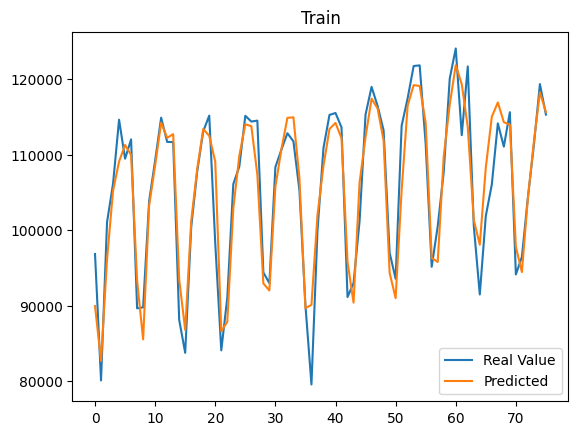

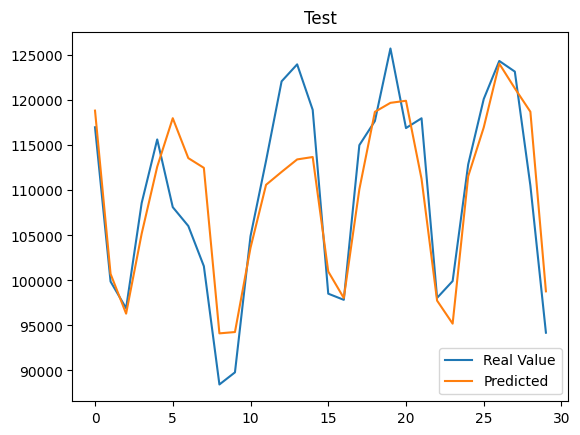

In [114]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [115]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [116]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred))
    smape = np.mean(numerator / denominator)
    return smape * 100

In [117]:
def evaluation(model_name, train_df, test_df, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_df['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_df['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_df['Demand'], train_prediction_df)


    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_df['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_df['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_df['Demand'], test_prediction_df)



In [118]:
evaluation('Random Forest', train_df, test_df, train_prediction_df, test_prediction_df)

Random Forest train scores:
MAE : 23.338468835588632
MSE : 5569.476994555948
MAPE : 601761271720006.0
Random Forest test scores:
MAE : 29.11827551525892
MSE : 7833.672115721684
MAPE : 600663900139156.0


# File Saving

In [119]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [120]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [121]:
labeled_prediction_df = prediction_labeling(test_prediction_df, test_df)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [122]:
print(f'labeled prediction dataframe shape : {labeled_prediction_df.shape}')
labeled_prediction_df.head()

labeled prediction dataframe shape : (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,12.398129
1,1,2023-04-02,14.136445
2,1,2023-04-03,9.355093
3,1,2023-04-04,10.270024
4,1,2023-04-05,9.613674


In [123]:
save_predictions(labeled_prediction_df, OUTPUT_PATH)